# Imports 

In [12]:
from __future__ import print_function
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
import warnings
warnings.filterwarnings('ignore')

In [13]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


# Load Dataset
WELFake from HuggingFace

In [14]:
from datasets import load_dataset

dataset = load_dataset("lelexuanzz/WELFake_stylo_feats")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords'],
        num_rows: 70793
    })
})


## Split dataset

In [15]:
#convert dataset to pandas for easier implementation with sklearn

df = dataset["train"].to_pandas()
print(df)

                                                    text  label  has_quotes  \
0      No comment is expected from Barack Obama Membe...      1           0   
1       Now, most of the demonstrators gathered last ...      1           0   
2      A dozen politically active pastors came here f...      0           0   
3      The RS-28 Sarmat missile, dubbed Satan 2, will...      1           0   
4      All we can say on this one is it s about time ...      1           0   
...                                                  ...    ...         ...   
70788  WASHINGTON (Reuters) - Hackers believed to be ...      0           0   
70789  You know, because in fantasyland Republicans n...      1           0   
70790  Migrants Refuse To Leave Train At Refugee Camp...      0           1   
70791  MEXICO CITY (Reuters) - Donald Trump’s combati...      0           0   
70792  Goldman Sachs Endorses Hillary Clinton For Pre...      1           0   

       has_url  percent_uppercase  frequency_punctu

### Train with original 10 features

In [18]:
from sklearn.model_selection import train_test_split

features_orig_10 = ['has_quotes', 'has_url', 'percent_uppercase', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'percent_whitespace', 'avg_sentence_length', 'frequency_punctuation']
seed = 45

y = df["label"]
x = df[features_orig_10]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)

display(x_train)
display(y_train)

,has_quotes,has_url,percent_uppercase,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,percent_whitespace,avg_sentence_length,frequency_punctuation
33090,0,0,4.365983,0,0,3,2,16.362946,27.937500,42
13814,0,1,2.970607,1,1,3,12,16.823014,19.551724,70
47609,0,0,3.880804,0,0,2,3,16.770617,25.200000,29
30722,0,0,3.251016,0,1,4,5,16.723976,17.718750,67
1945,0,1,2.789491,0,1,3,9,16.477457,24.090909,77
...,...,...,...,...,...,...,...,...,...,...
12895,0,1,3.202995,0,1,3,8,18.219634,21.857143,61
60960,0,1,2.864939,0,0,3,6,17.189632,28.000000,32
6012,0,1,17.731959,0,0,1,0,17.113402,14.833333,11
63107,0,0,3.806452,0,1,1,2,17.161290,27.600000,30


33090    0
13814    1
47609    0
30722    0
1945     1
        ..
12895    1
60960    1
6012     1
63107    1
6558     1
Name: label, Length: 56634, dtype: int64

### Training

no further preprocessing

In [19]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [20]:
#instantiate with default params first
rf = RandomForestClassifier(random_state=seed)
rf.fit(x_train, y_train)

RandomForestClassifier(random_state=45)

In [21]:
y_pred = rf.predict(x_test)

In [22]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.8311321421004308


## Visualize feature importance

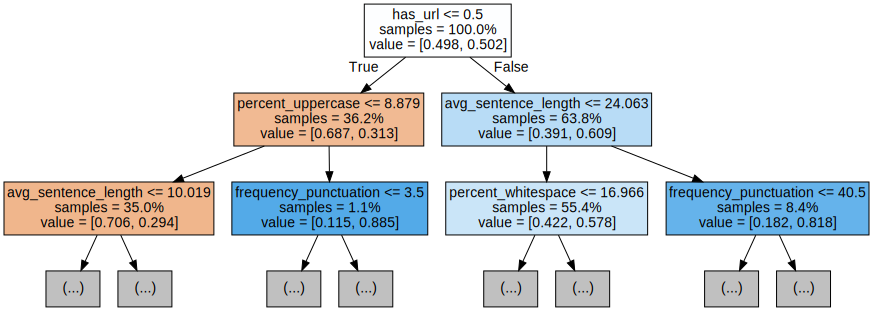

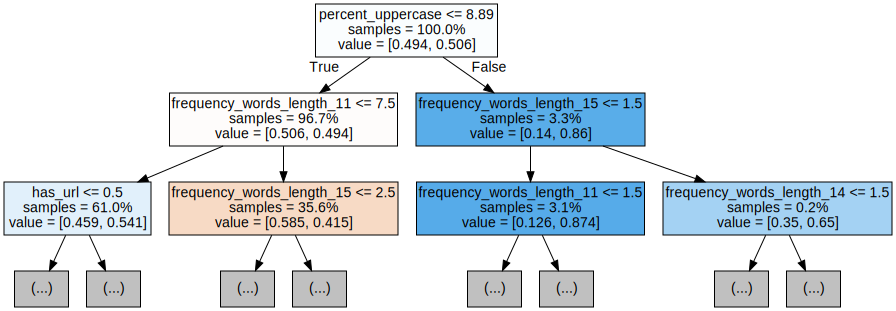

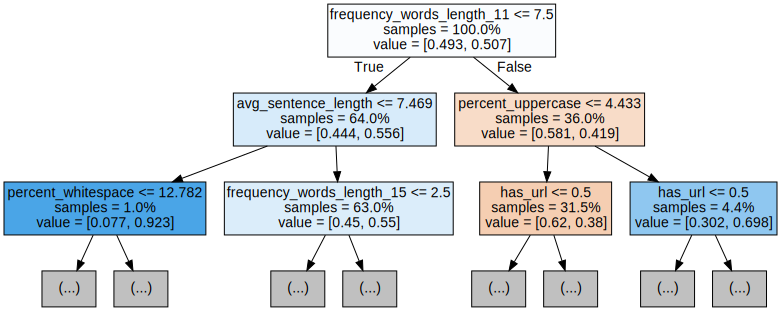

In [23]:
from sklearn.tree import export_graphviz
import graphviz

# Export the first three decision trees from the forest

for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

## Cross Validation

## Hyperparameter tuning

In [24]:
#randomizedsearchcv - includes cross validation
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {'n_estimators': randint(50,150),
              'max_depth': randint(3,15)}


# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=20, 
                                 cv=5,
                                 n_jobs=-1,
                                 random_state=seed)

# Fit the random search object to the data
rand_search.fit(x_train, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=45),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A975B50980>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x000001A90013B770>},
                   random_state=45)

In [25]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 14, 'n_estimators': 125}


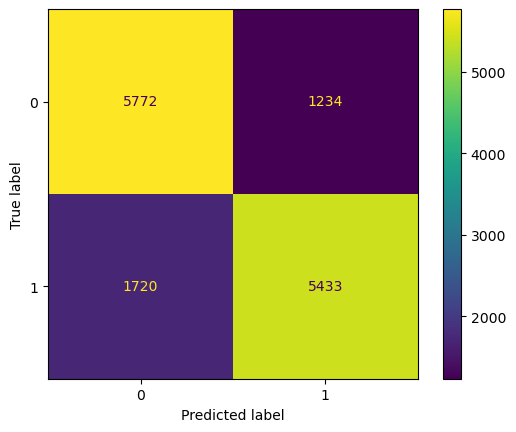

In [26]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
# Generate predictions with the best model
y_pred = best_rf.predict(x_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [27]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7913694469948442
Precision: 0.8149092545372731
Recall: 0.7595414511393821


## Results on test set

In [28]:
test_dataset = load_dataset("lelexuanzz/Gossipcop_Politifact_Test_Stylo")
print(test_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'has_quotes', 'has_url', 'percent_uppercase', 'frequency_punctuation', 'percent_whitespace', 'frequency_words_length_15', 'frequency_words_length_14', 'frequency_words_length_12', 'frequency_words_length_11', 'avg_sentence_length', 'has_1_to_3_urls', 'has_4_to_6_urls', 'has_more_than_6_urls', 'num_exclamations', 'num_questions', 'avg_word_length', 'lexical_diversity', 'proportion_stopwords'],
        num_rows: 6900
    })
})


In [29]:
test_df = test_dataset["train"].to_pandas()
display(test_df)


y_test_set = test_df["label"]
x_test_set = test_df[features_orig_10]

display(x_test_set)
display(y_test_set)

,text,label,has_quotes,has_url,percent_uppercase,frequency_punctuation,percent_whitespace,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,avg_sentence_length,has_1_to_3_urls,has_4_to_6_urls,has_more_than_6_urls,num_exclamations,num_questions,avg_word_length,lexical_diversity,proportion_stopwords
0,The media reported on “5 TikTok dances you can...,0,1,0,5.102041,32,17.040816,0,1,0,3,14.916667,0,0,0,0,2,4.482558,0.651163,0.401163
1,"""Over 240,000 'unverified' ballots have alread...",0,1,0,3.068897,181,15.636029,4,6,26,10,18.271186,0,0,0,2,0,5.078619,0.390221,0.423778
2,"Says ""Ron Johnson is making excuses for rioter...",1,1,1,3.742204,224,16.468666,0,3,12,7,16.619718,0,0,1,3,2,4.761525,0.428191,0.425532
3,“We have seen over the last 10 years ... under...,0,1,1,3.492849,107,16.529153,0,2,3,7,16.410256,0,1,0,0,0,4.758564,0.409462,0.419250
4,“I don’t get involved in the hiring and firing...,0,1,0,3.040541,139,16.394026,3,10,1,16,19.816327,0,0,0,0,0,4.737173,0.387435,0.409424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6895,Wedding Album: Dancing with the Stars Pro Lind...,0,0,0,7.645260,5,18.042813,0,0,0,1,20.666667,0,0,0,1,0,4.283333,0.816667,0.483333
6896,WATCH: Sneak Peek: Arizona's Furious Alex Atta...,0,0,0,9.923664,25,16.793893,0,0,0,0,23.000000,0,0,0,1,0,4.216495,0.690722,0.371134
6897,Mary Kay Letourneau 'Hopeful' She Can Fix Marr...,0,0,0,3.754171,94,15.656285,0,1,5,1,16.216216,0,0,0,0,1,4.602585,0.500808,0.462036
6898,Charlize Theron still upset Aeon Flux didn’t w...,0,0,0,3.329065,36,17.669654,0,0,0,1,18.250000,0,0,0,0,0,4.104730,0.577703,0.483108


,has_quotes,has_url,percent_uppercase,frequency_words_length_15,frequency_words_length_14,frequency_words_length_12,frequency_words_length_11,percent_whitespace,avg_sentence_length,frequency_punctuation
0,1,0,5.102041,0,1,0,3,17.040816,14.916667,32
1,1,0,3.068897,4,6,26,10,15.636029,18.271186,181
2,1,1,3.742204,0,3,12,7,16.468666,16.619718,224
3,1,1,3.492849,0,2,3,7,16.529153,16.410256,107
4,1,0,3.040541,3,10,1,16,16.394026,19.816327,139
...,...,...,...,...,...,...,...,...,...,...
6895,0,0,7.645260,0,0,0,1,18.042813,20.666667,5
6896,0,0,9.923664,0,0,0,0,16.793893,23.000000,25
6897,0,0,3.754171,0,1,5,1,15.656285,16.216216,94
6898,0,0,3.329065,0,0,0,1,17.669654,18.250000,36


0       0
1       0
2       1
3       0
4       0
       ..
6895    0
6896    0
6897    0
6898    0
6899    0
Name: label, Length: 6900, dtype: int64

In [30]:
y_test_pred = best_rf.predict(x_test_set)

In [31]:
accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred)
recall = recall_score(y_test_set, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.47289855072463766
Precision: 0.2894482090997096
Recall: 0.3846483704974271


# save model

In [32]:
import pickle

pickle.dump(best_rf, open("models/iter1_rf", 'wb'))

Results are a lot worse for test set compared to validation set - shows that random forest model overfit to the training data. 

Do randomsearch again, but reduce model complexity.

In [33]:
#test to see if model can be loaded

loaded_model = pickle.load(open('models/iter1_rf', 'rb'))

load_predict = loaded_model.predict(x_test_set)

accuracy = accuracy_score(y_test_set, load_predict)
precision = precision_score(y_test_set, load_predict)
recall = recall_score(y_test_set, load_predict)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.47289855072463766
Precision: 0.2894482090997096
Recall: 0.3846483704974271
